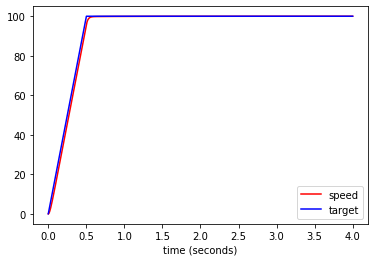

In [12]:
import sys
sys.path.append("../../")

import time
import math

from lib.data.dataplot import *
from lib.utils.time import *
from lib.system.controllers import *

class ElectricPart:

    def __init__(self, _R, _L):
        self.R = _R
        self.L = _L
        self.I = 0

    def evaluate(self, V, delta_t):
        self.I = (1 - self.R * delta_t / self.L) * self.I + delta_t / self.L * V
        return self.I


class TorqueToOmega:

    def __init__(self, _J, _b):
        self.J = _J
        self.b = _b
        self.w = 0

    def evaluate(self, T, delta_t):
        self.w = (1 - self.b * delta_t / self.J) * self.w + delta_t / self.J * T
        return self.w


class DCMotor:
    #
    # _R, resistance of the inductor
    # _L, impedence of the inductor
    # _Kt, torque coefficient
    # _Ke, BackEMF coefficient
    # _Wm, Wheel Mass
    # _Wr, Wheel Radius
    # _b, Friction coefficient
    #
    def __init__(self, _R, _L, _Kt, _Ke, _Wm, _Wr, _b):
        # inertial moment of the wheel
        _J = 0.5 * _Wm * _Wr**2
        # electric part
        self.electric = ElectricPart(_R, _L)
        # motion part
        self.torque_to_omega = TorqueToOmega(_J, _b)
        # other coefficients
        self.Kt =_Kt
        self.Ke = _Ke
        self.omega = 0

    def evaluate(self, delta_t, Vin):
        # electric part
        V = Vin - self.Ke * self.omega
        I = self.electric.evaluate(V, delta_t)
        Tm = I * self.Kt
        # omega computation
        T = Tm
        self.omega = self.torque_to_omega.evaluate(T, delta_t)
        return self.omega

class SpeedSmoother:
    
    def __init__(self, acc, max_speed):
        self.acceleration = acc
        self.max_speed = max_speed
        self.v = 0
        
    def evaluate(self, delta_t, speed):
        current_acc = (speed - self.v) / delta_t
        if current_acc > self.acceleration:
            self.v = self.v + self.acceleration * delta_t
            if self.v > self.max_speed:
                self.v = self.max_speed
        else:
            self.v = speed
        return self.v
        

dps = DataPlotter()
dps.set_x("time (seconds)")
dps.add_y("speed", "speed")
dps.add_y("target", "target")

m = DCMotor(1.45,     # R, 1.45 ohm
            130e-6,   # L, 130 microHenry
            0.0169,   # Kt, torque constant 16.9 mNm/A
            (60.0 * 0.00177)/(2*math.pi),  # Ke, back EMF constant, 1.77 mV/rpm
            0.1, # Wheel Mass 0.1kg
            0.05, # Wheel radius, 5cm
            7e-5) # friction

c = PI_Controller(0.5, 1.0, 12.0)
target = 100
s = SpeedSmoother(200.0, target)

current = m.omega

tm = Time()
tm.start()
t = tm.get()
while t < 4:

    time.sleep(0.0001)
    delta_t = tm.elapsed()
    t = tm.get()
    
    t2 = s.evaluate(delta_t, target)
    error = t2 - current
    v = c.evaluate(delta_t, error)
    current = m.evaluate(delta_t, v)

    #t += delta_t
    dps.append_x(t)
    dps.append_y("speed", current)
    dps.append_y("target", t2)
    
dps.plot()
